# Packages

In [1]:
!pip install argopy
!pip install seawater
!pip install holteandtalley
!pip install easy-tictoc

In [2]:
from datetime import timedelta
from scipy import stats, interpolate
from argopy import DataFetcher as ArgoDataFetcher
from seawater import dens
from holteandtalley import HolteAndTalley
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from tictoc import tic, toc
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

import pandas as pd
import numpy as np
import xarray as xr
import datetime as datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy
import os
import math
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate as interpolate
import cmath
import dask

# 0 - Functions

## MLD Functions

### (1) MLD_T by 0.2 degC

In [3]:
def MLD_of_T(Depth, T, z_ref):
    T_surf = np.mean(T[(Depth<=z_ref)])
    ind = np.where((T<T_surf-0.2) & (Depth>z_ref))
        # if not find MLD -- well mixing
    if len(ind[0]) == 0:
        MLD_T = np.max(Depthk)
        Allmix_T = 1
    else:
        MLD_T = np.min(Depth[ind[0]])
        Allmix_T = 0
    return MLD_T, Allmix_T
    

### (2) MLD_Rho by 0.03 

In [4]:
def MLD_of_Rho(Depth, Rho, z_ref):
    Rho_surf = np.mean(Rho[(Depth<=z_ref)])
    ind = np.where((Rho>Rho_surf + 0.03) & (Depth>z_ref))
        # if not find MLD -- well mixing
    if len(ind[0]) == 0:
        MLD_Rho = np.max(Depthk)
        Allmix_Rho = 1
    else:
        MLD_Rho = np.min(Depth[ind[0]])
        Allmix_Rho = 0
    return MLD_Rho, Allmix_Rho

## Process Functions

### (1) Unique

In [5]:
# Find unique element
def unique(list1):
        # insert the list to the set
    list_set = set(list1)
        # convert the set to the list
    unique_list = (list(list_set))
    return unique_list


### (2) nannorm

In [6]:
def nannorm(A):
    norm = np.sqrt(np.nansum(A*A))
    return norm

# # Test
# a = np.arange(9) - 4.0
# b = a.reshape((3, 3))
# b[1,1] = np.nan
# nannorm(b)

In [7]:
def generate_correlation_map(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,y.T) - n * np.dot(mu_x[:, np.newaxis],mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])





# 1 - Practice get MLD for 1 day

In [9]:
date_start = '2020-11-15'
date_end = '2020-11-16'
z_ref = 10
rho_0 = 1025
g = 9.8

## 1-1 Load Data

In [10]:
argo_loader = ArgoDataFetcher(src='argovis', parallel=True)
argo_loader.region([-180, 180, -90, 90, 0, 500, date_start, date_end]).load()
apDS = argo_loader.data

In [56]:
# # Plot Locations on world map
# argo_loader.plot('trajectory')
# plt.title(date_start+' to '+date_end)


## 1-2 Get MLD

In [12]:
platform_all = apDS.PLATFORM_NUMBER.values.flatten()   #.tolist()
platform_unique = unique(platform_all)
tic()

    # Valid profile info 
Lat_prof = []
Lon_prof = []
Zmax_prof = []
platform_valid = []
    # T
MLD_T = []
Allmix_T = []
    # Rho
MLD_Rho = []
Allmix_Rho = []
    # Holte&Talley Rho
MLD_HTRho = []
MLD_HTS = []
MLD_HTT = []
Allmix_HTRho = []
    # Max Buoyancy Frequency
MLD_maxN = []
Allmix_maxN = []
for k in range(len(platform_unique)):
# ------------------------------------------------------------------------
# (0) Load Data for this platform
    platformk = platform_unique[k]
    ind = np.where(platform_all == platformk)
    latk = apDS.LATITUDE[ind].values
    lonk = apDS.LONGITUDE[ind].values
    Tk = apDS.TEMP[ind].values
    Sk = apDS.PSAL[ind].values
    Pk = apDS.PRES[ind].values
    
# ------------------------------------------------------------------------
# (1) Examinations
    # (a) if one profile 
    ind_neg = np.where(np.diff(Pk)<-0.1)
    if len(ind_neg[0]) > 0:
        continue
        # print(str(k)+'th platform - '+str(platformk)+' has more than 1 profile')
        
    # (b) if shallow enough for reference
    if np.min(Pk) > z_ref:
        continue
    
    # (c) if deep enough (say 50m)
    if np.max(Pk) < 50:
        continue
        
    # (d) if enough point
    if len(Pk) < 10:
        continue
    
    # (e) if too much NaN
    indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
    indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
    if (len(indexk_realS)<0.5*len(Pk)) | (len(indexk_realT)<0.5*len(Pk)):
        continue
# ------------------------------------------------------------------------
# (2) Remove NaN & smooth & get unique values
    interp_func_S = interpolate.interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
    Sk = savgol_filter(interp_func_S(Pk),20,3)
    interp_func_T = interpolate.interp1d(Pk[indexk_realT], Tk[indexk_realT], kind='nearest', fill_value='extrapolate')
    Tk = savgol_filter(interp_func_T(Pk),20,3)
    
    Sk_uni, index_uniqueS = np.unique(Sk,return_index=True)
    Tk_uni, index_uniqueT = np.unique(Tk,return_index=True)
    Pk_uni, index_uniqueP = np.unique(Pk,return_index=True)
    ind_unique = np.intersect1d(index_uniqueP,np.intersect1d(index_uniqueS, index_uniqueT))
    
    Sk = Sk[ind_unique]
    Tk = Tk[ind_unique]
    Pk = Pk[ind_unique]
    latk = latk[ind_unique]
    lonk = lonk[ind_unique]
# ------------------------------------------------------------------------
# (3) get Rho & Depth step by step 
    g = 9.81
    Rhok0 = np.empty(np.size(Pk))
    Depthk = np.empty(np.size(Pk))
        # Density with Pressure -- to calculate depth
    Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
    Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

    for j in np.arange(1,len(Depthk)):  # for each depth in the profile
        Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
        Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g
    
    # Get Potential Density -- p=0
    Rhok = savgol_filter(dens(Sk,Tk,0) - 1000,20,3)
# ------------------------------------------------------------------------
# (4) MLD-T -- by -0.2 degC
    MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)
    MLD_T.append(MLD_Tk)
    Allmix_T.append(Allmix_Tk)
    
# ------------------------------------------------------------------------
# (5) MLD-Rho -- by +0.03
    MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)
    MLD_Rho.append(MLD_Rhok)
    Allmix_Rho.append(Allmix_Rhok)
# ------------------------------------------------------------------------
# (6) MLD-Holte_and_Talley
    h = HolteAndTalley(Pk,Tk,Sk,Rhok)
    MLD_HTRho.append(h.densityMLD)
    MLD_HTS.append(h.salinityMLD)
    MLD_HTT.append(h.tempMLD)
    if abs(h.densityMLD - np.max(Depthk)) < 1e-1:
        Allmix_HTRho.append(1)
    else:
        Allmix_HTRho.append(0)
        
# ------------------------------------------------------------------------
# (7) MLD-maxN
    Zk = -Depthk
    N2k = -g/rho_0 * (Rhok[:-1]-Rhok[1:])/(Zk[:-1]-Zk[1:])
    Depth_N2k = Depthk[:-1]
    ind_maxNk = np.argmax(N2k[Depth_N2k>z_ref])
    Depth_belowref = Depth_N2k[Depth_N2k>z_ref]
    MLD_maxNk = Depth_belowref[ind_maxNk]
    MLD_maxN.append(MLD_maxNk)
    
# ------------------------------------------------------------------------
# (8) MLD_dN & Quality Index (QI)
    

    
# ------------------------------------------------------------------------
# (X) Save station information    
    Lat_prof.append(np.mean(latk))
    Lon_prof.append(np.mean(lonk))
    Zmax_prof.append(np.max(Depthk))
    platform_valid.append(platformk)
    
toc()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0:00:25.928372


In [13]:
h.tempMLD

81.1

In [14]:
# Put into dataset
col_names = ['Profile','Lat','Lon','MLD_T','MLD_Rho','MLD_HTRho','MLD_HTS','MLD_HTT','MLD_maxN']
data = np.transpose([platform_valid,Lat_prof,Lon_prof,MLD_T,MLD_Rho,MLD_HTRho,MLD_HTS,MLD_HTT,MLD_maxN])
df_MLD = pd.DataFrame(data, columns=col_names)
df_MLD

,Profile,Lat,Lon,MLD_T,MLD_Rho,MLD_HTRho,MLD_HTS,MLD_HTT,MLD_maxN
0,5902344.0,-28.851960,100.258920,31.849322,25.845865,23.50,23.5,22.080000,35.785087
1,5902348.0,-35.363720,96.465340,81.509445,77.458641,71.96,77.5,78.000000,83.455347
2,5902351.0,-28.654140,88.623170,35.815686,31.761510,31.96,31.5,31.960000,41.856647
3,4902929.0,18.765000,-106.576000,35.838661,33.743926,7.82,15.5,21.044077,45.807775
4,5902353.0,-31.387670,67.164740,37.800639,33.826283,31.96,33.0,36.080000,41.695193
...,...,...,...,...,...,...,...,...,...
356,5904370.0,-40.547530,162.024140,31.781037,11.919188,10.00,10.0,15.960000,10.647900
357,5904372.0,-38.435060,161.361540,23.847385,13.832164,14.00,14.0,10.640000,65.608032
358,4902903.0,19.896000,-106.510000,15.671299,13.677689,7.72,12.5,13.736430,39.877216
359,6901750.0,46.223000,-19.261000,54.603903,34.750099,31.50,31.5,35.000000,85.371142


In [15]:
df_MLD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Profile    361 non-null    float64
 1   Lat        361 non-null    float64
 2   Lon        361 non-null    float64
 3   MLD_T      361 non-null    float64
 4   MLD_Rho    361 non-null    float64
 5   MLD_HTRho  361 non-null    float64
 6   MLD_HTS    361 non-null    float64
 7   MLD_HTT    361 non-null    float64
 8   MLD_maxN   361 non-null    float64
dtypes: float64(9)
memory usage: 25.5 KB


In [14]:

Nk = np.full(len(N2k),np.nan)
Nk[N2k<0] = [ -np.abs(cmath.sqrt(np.min(N2k)).imag) for N_neg in N2k[N2k<0]]
Nk[N2k>0] = np.sqrt(N2k[N2k>0])





## 1-3 Grid Data

In [15]:
# Scipy.interpoalte.griddata
    # points - [x,y]
Lat_vec = np.linspace(-60,60,121)
Lon_vec = np.linspace(-180,180,721)
Lon_grid, Lat_grid = np.meshgrid(Lon_vec, Lat_vec)
points = np.transpose(np.concatenate((np.array([Lon_prof,]),np.array([Lat_prof,])),axis=0))

for name in col_names[3:]:
    exec('values ='+ name)
    exec(name+"_grid = interpolate.griddata(points, values, (Lon_grid, Lat_grid), method='cubic')")
    

[-75.53691,
 -95.33506999999999,
 100.25892000000002,
 101.36391000000002,
 96.46533999999997,
 76.48589,
 88.62317,
 -106.576,
 67.16474,
 69.59347,
 -134.88100000000003,
 66.86602000000003,
 -134.64100000000002,
 69.11750000000004,
 -165.467,
 63.621170000000006,
 -98.88059,
 61.83299999999999,
 -139.40974000000003,
 -92.30681000000001,
 122.27881999999998,
 -87.07826,
 -85.24619,
 -79.87811999999998,
 132.507,
 62.77200000000002,
 -97.79999999999998,
 -156.568,
 149.37,
 29.14909666666665,
 73.394,
 -153.95000000000002,
 -148.41100000000003,
 -149.554,
 37.36,
 -163.998,
 -32.1038,
 36.00562333333335,
 -44.1114,
 38.3007,
 49.289,
 -52.3315,
 -141.88119000000003,
 -135.57293,
 60.17170000000001,
 -111.52120333333335,
 -151.60978000000003,
 -126.80881,
 -127.80530000000002,
 5.3705,
 -35.5647,
 126.63218000000006,
 -166.97228999999996,
 -73.47835999999997,
 -164.88178999999997,
 -143.412,
 -136.77216999999996,
 -71.14268000000001,
 -135.80964999999995,
 157.20696,
 -50.46996000000001

# 1.5 - Function to get MLD for one day

In [ ]:
def MLDfromArgo(date_start, date_end, z_ref)
# Load Data
    argo_loader = ArgoDataFetcher(src='argovis', parallel=True)
    argo_loader.region([-180, 180, -90, 90, 0, 500, date_start, date_end]).load()
    apDS = argo_loader.data
    
    platform_all = apDS.PLATFORM_NUMBER.values.flatten()   #.tolist()
    platform_unique = unique(platform_all)
# ========================================================================================================================
# ========================================================================================================================
# Get MLD
        # Valid profile info 
    Lat_prof = []
    Lon_prof = []
    Zmax_prof = []
    platform_valid = []
        # T
    MLD_T = []
    Allmix_T = []
        # Rho
    MLD_Rho = []
    Allmix_Rho = []
        # Holte&Talley Rho
    MLD_HTRho = []
    MLD_HTS = []
    MLD_HTT = []
    Allmix_HTRho = []
        # Max Buoyancy Frequency
    MLD_maxN = []
    Allmix_maxN = []
    
    for k in range(len(platform_unique)):
    # ------------------------------------------------------------------------
    # (0) Load Data for this platform
        platformk = platform_unique[k]
        ind = np.where(platform_all == platformk)
        latk = apDS.LATITUDE[ind].values
        lonk = apDS.LONGITUDE[ind].values
        Tk = apDS.TEMP[ind].values
        Sk = apDS.PSAL[ind].values
        Pk = apDS.PRES[ind].values

    # ------------------------------------------------------------------------
    # (1) Examinations
        # (a) if one profile 
        ind_neg = np.where(np.diff(Pk)<-0.1)
        if len(ind_neg[0]) > 0:
            continue
            # print(str(k)+'th platform - '+str(platformk)+' has more than 1 profile')

        # (b) if shallow enough for reference
        if np.min(Pk) > z_ref:
            continue

        # (c) if deep enough (say 50m)
        if np.max(Pk) < 50:
            continue

        # (d) if enough point
        if len(Pk) < 10:
            continue

        # (e) if too much NaN
        indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
        indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
        if (len(indexk_realS)<0.5*len(Pk)) | (len(indexk_realT)<0.5*len(Pk)):
            continue
    # ------------------------------------------------------------------------
    # (2) Remove NaN & smooth & get unique values
        interp_func_S = interpolate.interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
        Sk = savgol_filter(interp_func_S(Pk),20,3)
        interp_func_T = interpolate.interp1d(Pk[indexk_realT], Tk[indexk_realT], kind='nearest', fill_value='extrapolate')
        Tk = savgol_filter(interp_func_T(Pk),20,3)

        Sk_uni, index_uniqueS = np.unique(Sk,return_index=True)
        Tk_uni, index_uniqueT = np.unique(Tk,return_index=True)
        Pk_uni, index_uniqueP = np.unique(Pk,return_index=True)
        ind_unique = np.intersect1d(index_uniqueP,np.intersect1d(index_uniqueS, index_uniqueT))

        Sk = Sk[ind_unique]
        Tk = Tk[ind_unique]
        Pk = Pk[ind_unique]
        latk = latk[ind_unique]
        lonk = lonk[ind_unique]
    # ------------------------------------------------------------------------
    # (3) get Rho & Depth step by step 
        g = 9.81
        Rhok0 = np.empty(np.size(Pk))
        Depthk = np.empty(np.size(Pk))
            # Density with Pressure -- to calculate depth
        Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
        Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

        for j in np.arange(1,len(Depthk)):  # for each depth in the profile
            Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
            Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g

        # Get Potential Density -- p=0
        Rhok = savgol_filter(dens(Sk,Tk,0) - 1000,20,3)
        
        
        
        
        
        
    # ------------------------------------------------------------------------
    # (4) MLD-T -- by -0.2 degC
        MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)
        
        MLD_T.append(MLD_Tk)
        Allmix_T.append(Allmix_Tk)

    # ------------------------------------------------------------------------
    # (5) MLD-Rho -- by +0.03
        MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)
        MLD_Rho.append(MLD_Rhok)
        Allmix_Rho.append(Allmix_Rhok)
    # ------------------------------------------------------------------------
    # (6) MLD-Holte_and_Talley
        h = HolteAndTalley(Pk,Tk,Sk,Rhok)
        MLD_HTRho.append(h.densityMLD)
        MLD_HTS.append(h.salinityMLD)
        MLD_HTT.append(h.tempMLD)
        if abs(h.densityMLD - np.max(Depthk)) < 1e-1:
            Allmix_HTRho.append(1)
        else:
            Allmix_HTRho.append(0)

    # ------------------------------------------------------------------------
    # (7) MLD-maxN
        Zk = -Depthk
        N2k = -g/rho_0 * (Rhok[:-1]-Rhok[1:])/(Zk[:-1]-Zk[1:])
        Depth_N2k = Depthk[:-1]
        ind_maxNk = np.argmax(N2k[Depth_N2k>z_ref])
        Depth_belowref = Depth_N2k[Depth_N2k>z_ref]
        MLD_maxNk = Depth_belowref[ind_maxNk]
        MLD_maxN.append(MLD_maxNk)

    # ------------------------------------------------------------------------
    # (8) MLD_dN & Quality Index (QI)



    # ------------------------------------------------------------------------
    # (X) Save station information    
        Lat_prof.append(np.mean(latk))
        Lon_prof.append(np.mean(lonk))
        Zmax_prof.append(np.max(Depthk))
        platform_valid.append(platformk)
        
        dic = {}
        
        col_names = ['Profile','Lat','Lon','MLD_T','MLD_Rho','MLD_HTRho','MLD_HTS','MLD_HTT','MLD_maxN']
        data = np.transpose([platform_valid,Lat_prof,Lon_prof,MLD_T,MLD_Rho,MLD_HTRho,MLD_HTS,MLD_HTT,MLD_maxN])
        df_MLD_1row = pd.DataFrame(data, columns=col_names)
    
# # =========================================================================================================================================
# # =========================================================================================================================================
# # Put into dataset
#     col_names = ['Profile','Lat','Lon','MLD_T','MLD_Rho','MLD_HTRho','MLD_HTS','MLD_HTT','MLD_maxN']
#     data = np.transpose([platform_valid,Lat_prof,Lon_prof,MLD_T,MLD_Rho,MLD_HTRho,MLD_HTS,MLD_HTT,MLD_maxN])
#     df_MLD = pd.DataFrame(data, columns=col_names)
#     return df_MLD





In [28]:
bad_profs = list(set(apDS.PLATFORM_NUMBER.values).difference(df_MLD.Profile.values))
platformk = bad_profs[0]
# ind = np.where(platform_all == platformk)
# latk = apDS.LATITUDE[ind].values
# lonk = apDS.LONGITUDE[ind].values
# Tk = apDS.TEMP[ind].values
# Sk = apDS.PSAL[ind].values
# Pk = apDS.PRES[ind].values
getprof_1platform(platformk)

AttributeError: 'NoneType' object has no attribute 'size'

## (1) Check Profile Quality

In [116]:
def profQ(platformk):
    # platformk = platform_unique[k]
    ind = np.where(platform_all == platformk)
    latk = apDS.LATITUDE[ind].values
    lonk = apDS.LONGITUDE[ind].values
    Tk = apDS.TEMP[ind].values
    Sk = apDS.PSAL[ind].values
    Pk = apDS.PRES[ind].values

    # ------------------------------------------------------------------------
    # (1) Examinations
    # (a) if one profile 
    prof = 1
    ind_neg = np.where(np.diff(Pk)<-0.1)
    if len(ind_neg[0]) > 0:
        prof = 0
        # print(str(k)+'th platform - '+str(platformk)+' has more than 1 profile')

    # (b) if shallow enough for reference
    if np.min(Pk) > z_ref:
        prof = 0

    # (c) if deep enough (say 50m)
    if np.max(Pk) < 50:
        prof = 0

    # (d) if enough point
    if len(Pk) < 10:
        prof = 0

    # (e) if too much NaN
    indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
    indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
    if (len(indexk_realS)<0.5*len(Pk)) | (len(indexk_realT)<0.5*len(Pk)):
        prof = 0
    
    return prof

## (2) Get MLD

In [209]:
# get profile for 1 platform
def getMLD_1prof(platformk):
    
    # platformk = platform_unique[k]
    ind = np.where(platform_all == platformk)
    latk = apDS.LATITUDE[ind].values
    lonk = apDS.LONGITUDE[ind].values
    Tk = apDS.TEMP[ind].values
    Sk = apDS.PSAL[ind].values
    Pk = apDS.PRES[ind].values
    
    Datetimek = datetime.datetime.strptime(np.datetime_as_string(apDS.TIME[0].values, unit='D'), '%Y-%m-%d')
    # ------------------------------------------------------------------------
    # (2) Remove NaN & smooth & get unique values
    indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
    indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
    interp_func_S = interpolate.interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
    Sk = savgol_filter(interp_func_S(Pk),5,3)
    interp_func_T = interpolate.interp1d(Pk[indexk_realT], Tk[indexk_realT], kind='nearest', fill_value='extrapolate')
    Tk = savgol_filter(interp_func_T(Pk),5,3)

    Sk_uni, index_uniqueS = np.unique(Sk,return_index=True)
    Tk_uni, index_uniqueT = np.unique(Tk,return_index=True)
    Pk_uni, index_uniqueP = np.unique(Pk,return_index=True)
    ind_unique = np.intersect1d(index_uniqueP,np.intersect1d(index_uniqueS, index_uniqueT))

    Sk = Sk[ind_unique]
    Tk = Tk[ind_unique]
    Pk = Pk[ind_unique]
    latk = latk[ind_unique]
    lonk = lonk[ind_unique]
    # ------------------------------------------------------------------------
    # (3) get Rho & Depth step by step 
    g = 9.81
    Rhok0 = np.empty(np.size(Pk))
    Depthk = np.empty(np.size(Pk))
        # Density with Pressure -- to calculate depth
    Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
    Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

    for j in np.arange(1,len(Depthk)):  # for each depth in the profile
        Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
        Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g

    # Get Potential Density -- p=0
    Rhok = savgol_filter(dens(Sk,Tk,0) - 1000,5,3)

   # ------------------------------------------------------------------------
    # (4) MLD-T -- by -0.2 degC
    MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)

    # ------------------------------------------------------------------------
    # (5) MLD-Rho -- by +0.03
    MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)

    # ------------------------------------------------------------------------
    # (6) MLD-Holte_and_Talley
    h = HolteAndTalley(Pk,Tk,Sk,Rhok)
    MLD_HTRhok = h.densityMLD 
    MLD_HTSk = h.salinityMLD        
    MLD_HTTk = h.tempMLD   
    if abs(h.densityMLD - np.max(Depthk)) < 1e-1:
        Allmix_HTRho.append(1)
    else:
        Allmix_HTRho.append(0)

    # ------------------------------------------------------------------------
    # (7) MLD-maxN
    Zk = -Depthk
    N2k = -g/rho_0 * (Rhok[:-1]-Rhok[1:])/(Zk[:-1]-Zk[1:])
    Depth_N2k = Depthk[:-1]
    ind_maxNk = np.argmax(N2k[Depth_N2k>z_ref])
    Depth_belowref = Depth_N2k[Depth_N2k>z_ref]
    MLD_maxNk = Depth_belowref[ind_maxNk]

    # ------------------------------------------------------------------------
    # (8) MLD_dN & Quality Index (QI)



    # ------------------------------------------------------------------------
    # (X) Save station information    
    Lat_profk = np.mean(latk)
    Lon_profk = np.mean(lonk) 
    Zmax_profk = np.max(Depthk)
    platform_validk = platformk

    dic = {}

    col_names = [['Time','Profile','Lat','Lon','MLD_T','MLD_Rho','MLD_HTRho','MLD_HTS','MLD_HTT','MLD_maxN'],]
    data = [[Datetimek,platform_validk,Lat_profk,Lon_profk,MLD_Tk,MLD_Rhok,MLD_HTRhok,MLD_HTSk,MLD_HTTk,MLD_maxNk],]
    df_MLD_1prof = pd.DataFrame(data, columns=col_names)
    return df_MLD_1prof
    




# !!! Run through all year with dask !!!

## (1) create dask & create pathway

In [210]:
# all year
dates_dt = datetime.datetime(2020,1,1)+ np.arange(0,367) * datetime.timedelta(days=1)
# 1 week
dates_dt = datetime.datetime(2020,1,1)+ np.arange(0,7) * datetime.timedelta(days=1)
# # 1 day
# dates_dt = datetime.datetime(2020,1,1)+ np.arange(0,2) * datetime.timedelta(days=1)

col_names = [['Time','Profile','Lat','Lon','MLD_T','MLD_Rho','MLD_HTRho','MLD_HTS','MLD_HTT','MLD_maxN'],]
df_all = pd.DataFrame(columns=col_names)
for daynum in range(len(dates_dt)-1):
    # get date_start and date_end in string
    date_start = dates_dt[daynum].strftime("%Y-%m-%d")
    date_end = dates_dt[daynum+1].strftime("%Y-%m-%d")
    
    argo_loader = ArgoDataFetcher(src='argovis', parallel=True)
    argo_loader.region([-180, 180, -90, 90, 0, 500, date_start, date_end]).load()
    apDS = argo_loader.data
    
    platform_all = apDS.PLATFORM_NUMBER.values.flatten()   #.tolist()
    platform_unique = unique(platform_all)
    
    
    df_MLD1prof_all = pd.DataFrame(columns=col_names)
    for platformk in platform_unique:
        # (1) Check profile quality 
        prof = profQ(platformk)
        if prof == 0:   # no good profile in this platform
            continue
        elif prof == 1:        
        # (2) get MLD
            df_MLD1prof_all = pd.concat([df_MLD1prof_all,getMLD_1prof(platformk)])
        # df_MLD1prof_all.append(getMLD_1prof(platformk))
        
        
    df_all = pd.concat([df_all,df_MLD1prof_all])
    # df_all.append(df_MLD1prof_all)
    
    
    
    
    
    # df_all.append(   deplayed(MLDfromArgo)(date)      )

# ccombine list of list of df into one df

In [203]:
print(daynum, platformk)
type(platformk)

3 6902842.0


numpy.float64

In [204]:
daynum = 3
platformk = 6902842.0
date_start = dates_dt[daynum].strftime("%Y-%m-%d")
date_end = dates_dt[daynum+1].strftime("%Y-%m-%d")

argo_loader = ArgoDataFetcher(src='argovis', parallel=True)
argo_loader.region([-180, 180, -90, 90, 0, 500, date_start, date_end]).load()
apDS = argo_loader.data


In [205]:
platform_all = apDS.PLATFORM_NUMBER.values.flatten()   #.tolist()
platform_unique = unique(platform_all)
df_MLD1prof_all = pd.DataFrame(columns=col_names)
df_MLD_1prof = getMLD_1prof(platformk)
df_MLD_1prof
# for k in range(len(platform_unique)):
#     platformk = platform_unique[k]
#     prof = profQ(platformk)
#     if prof == 1:
#         print(k)
#         df_MLD_1prof = getMLD_1prof(platformk)



ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [206]:
ind = np.where(platform_all == platformk)
latk = apDS.LATITUDE[ind].values
lonk = apDS.LONGITUDE[ind].values
Tk = apDS.TEMP[ind].values
Sk = apDS.PSAL[ind].values
Pk = apDS.PRES[ind].values

Datetimek = datetime.datetime.strptime(np.datetime_as_string(apDS.TIME[0].values, unit='D'), '%Y-%m-%d')
# ------------------------------------------------------------------------
# (2) Remove NaN & smooth & get unique values
indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
interp_func_S = interpolate.interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
Sk = savgol_filter(interp_func_S(Pk),20,3)
interp_func_T = interpolate.interp1d(Pk[indexk_realT], Tk[indexk_realT], kind='nearest', fill_value='extrapolate')
Tk = savgol_filter(interp_func_T(Pk),20,3)

Sk_uni, index_uniqueS = np.unique(Sk,return_index=True)
Tk_uni, index_uniqueT = np.unique(Tk,return_index=True)
Pk_uni, index_uniqueP = np.unique(Pk,return_index=True)
ind_unique = np.intersect1d(index_uniqueP,np.intersect1d(index_uniqueS, index_uniqueT))

Sk = Sk[ind_unique]
Tk = Tk[ind_unique]
Pk = Pk[ind_unique]
latk = latk[ind_unique]
lonk = lonk[ind_unique]
# ------------------------------------------------------------------------
# (3) get Rho & Depth step by step 
g = 9.81
Rhok0 = np.empty(np.size(Pk))
Depthk = np.empty(np.size(Pk))
    # Density with Pressure -- to calculate depth
Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

for j in np.arange(1,len(Depthk)):  # for each depth in the profile
    Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
    Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g

# Get Potential Density -- p=0
Rhok = savgol_filter(dens(Sk,Tk,0) - 1000,20,3)
MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)
# MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [208]:
savgol_filter(interp_func_S(Pk),20,3)

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

# 2 - Global Map

## 2-1 Original point scatter

### (a) MLD_Rho

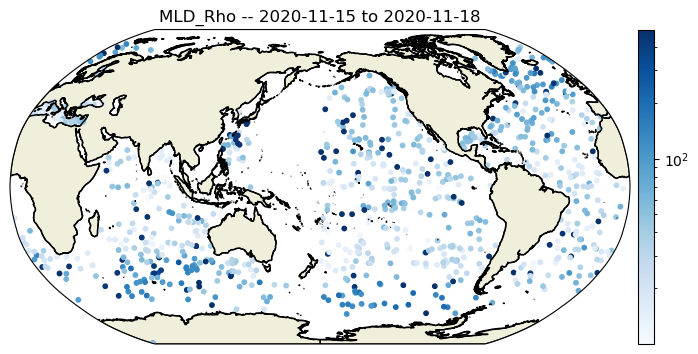

In [16]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines(resolution='50m')
# ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.set_title('MLD_Rho -- '+date_start+' to '+date_end)

sc = ax.scatter(Lon_prof, Lat_prof, c=MLD_Rho, s=10, transform=ccrs.PlateCarree(),norm=matplotlib.colors.LogNorm(),cmap='Blues')
# plt.colorbar(sc,ax=ax)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
# cbar.set_clim(10, 500)

### (x) MLD_maxN

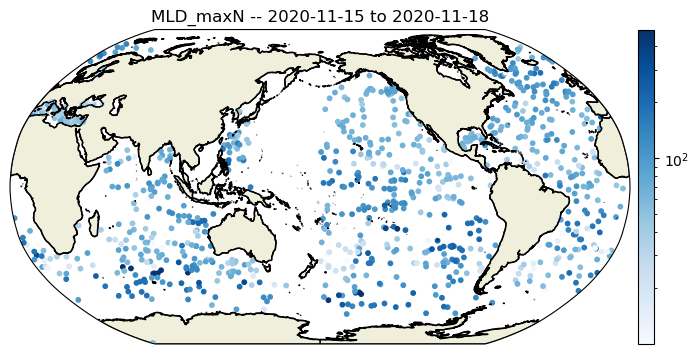

In [17]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines(resolution='50m')
# ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.set_title('MLD_maxN -- '+date_start+' to '+date_end)

sc = ax.scatter(Lon_prof, Lat_prof, c=MLD_maxN, s=10, transform=ccrs.PlateCarree(),norm=matplotlib.colors.LogNorm(),cmap='Blues')
# plt.colorbar(sc,ax=ax)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
# cbar.set_clim(10, 500)

### (y) MLD_HTRho

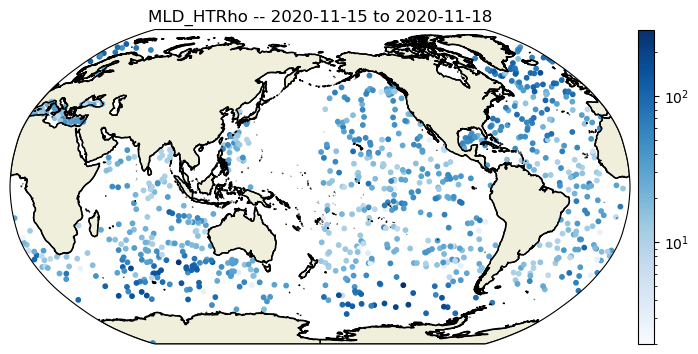

In [18]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines(resolution='50m')
# ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.set_title('MLD_HTRho -- '+date_start+' to '+date_end)

sc = ax.scatter(Lon_prof, Lat_prof, c=MLD_HTRho, s=10, transform=ccrs.PlateCarree(),norm=matplotlib.colors.LogNorm(),cmap='Blues')
# plt.colorbar(sc,ax=ax)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(sc, cax=cax) # Similar to fig.colorbar(im, cax = cax)
# cbar.set_clim(10, 500)

## 2-2 interp mesh plot -- Need into 2D

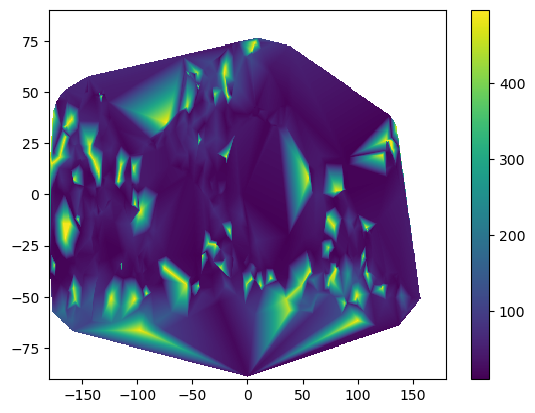

In [19]:
Lat_grid = np.linspace(-90,90,361)
Lon_grid = np.linspace(-180,180,721)
Lon, Lat = np.meshgrid(Lon_grid, Lat_grid)
func_Rho = interpolate.LinearNDInterpolator(list(zip(Lon_prof, Lat_prof)), MLD_Rho)
MLD_Rho_interp = func_Rho(Lon, Lat)
pc = plt.pcolormesh(Lon, Lat, MLD_Rho_interp)
plt.colorbar(pc)

# 3 - Comparison

## 3-1 Mean & Std

<AxesSubplot: >

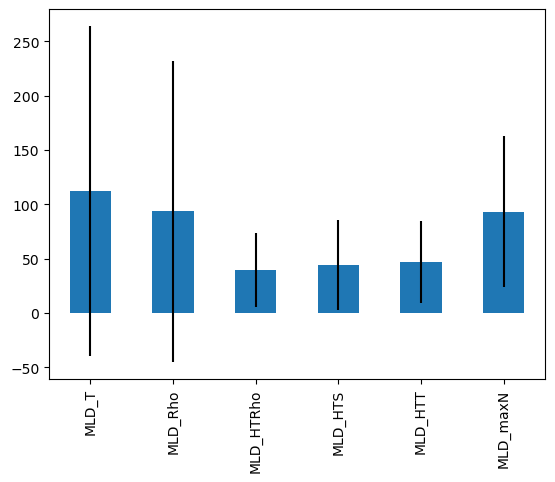

In [20]:
df_mean = df_MLD.mean()
df_std = df_MLD.std()

df_mean[3:].plot.bar(yerr=df_std[3:])

In [45]:
## zonal mean (each lat)
df_latmean = df_MLD.groupby(df_MLD.Lat).mean()
MLD_latmean = df_latmean.iloc[:,3:].values
np.shape(MLD_latmean)

# try to get corr
corr = scipy.signal.correlate2d(np.transpose(MLD_latmean), np.transpose(MLD_latmean),mode='same')
    
slope, intercept, R, P, std_err = scipy.stats.linregress(MLD_latmean[:,0],MLD_latmean[:,2])
print(R)
print(P)

0.2873847768326888
3.71164930269437e-18


In [23]:
## Correlation

In [25]:
corr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

TypeError: Dimensions of C (121, 721) are incompatible with X (721) and/or Y (361); see help(pcolor)

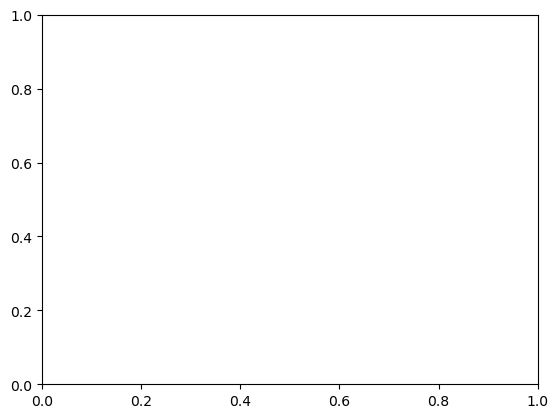

In [26]:
p = plt.pcolor(Lon_grid,Lat_grid,corr, vmin=10, vmax=500)
plt.colorbar(p)

In [ ]:
# Cosine Similarity

In [ ]:
cosim = 1 - scipy.spatial.distance.cdist(MLD_Rho_grid, MLD_HTRho_grid, 'cosine')

In [ ]:
# norm-distance 1

In [ ]:
# Rho & HotleTalley
np.nansum(MLD_Rho_grid * MLD_HTRho_grid) / (nannorm(MLD_Rho_grid) * nannorm(MLD_HTRho_grid) )
# Rho & T
np.nansum(MLD_Rho_grid * MLD_T_grid) / (nannorm(MLD_Rho_grid) * nannorm(MLD_T_grid) )
# Rho & maxN
np.nansum(MLD_Rho_grid * MLD_maxN_grid) / (nannorm(MLD_Rho_grid) * nannorm(MLD_maxN_grid) )
# ------------
# HotleTalley & maxN
np.nansum(MLD_HTRho_grid * MLD_maxN_grid) / (nannorm(MLD_HTRho_grid) * nannorm(MLD_maxN_grid) )

In [ ]:
# np.linalg.norm(MLD_Rho_grid*)


# Drafts

In [ ]:
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)
z.shape()

In [ ]:
for k in np.arange(900,1200): 
    platformk = platform_unique[k]
    ind = np.where(platform_all == platformk)
    latk = apDS.LATITUDE[ind].values
    lonk = apDS.LONGITUDE[ind].values
    Tk = apDS.TEMP[ind].values
    Sk = apDS.PSAL[ind].values
    Pk = apDS.PRES[ind].values
    
# ------------------------------------------------------------------------
# (1) Examinations
    # (a) if one profile 
    ind_neg = np.where(np.diff(Pk)<-0.1)
    if len(ind_neg[0]) > 0:
        continue
        # print(str(k)+'th platform - '+str(platformk)+' has more than 1 profile')
        
    # (b) if shallow enough for reference
    if np.min(Pk) > z_ref:
        continue
    
    # (c) if deep enough (say 50m)
    if np.max(Pk) < 50:
        continue
        
    # (d) if enough point
    if len(Pk) < 10:
        continue
    
    # (e) if too much NaN
    indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
    indexk_realT = [m for m in range(len(Tk)) if ~np.isnan(Tk[m])]
    if (len(indexk_realS)<0.5*len(Pk)) | (len(indexk_realT)<0.5*len(Pk)):
        continue
# ------------------------------------------------------------------------
# (2) Remove NaN & smooth & get unique values
    interp_func_S = interpolate.interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
    Sk = gaussian_filter1d(interp_func_S(Pk),sigma=5)
    interp_func_T = interpolate.interp1d(Pk[indexk_realT], Tk[indexk_realT], kind='nearest', fill_value='extrapolate')
    Tk = gaussian_filter1d(interp_func_T(Pk),sigma=5)
    
    Sk_uni, index_uniqueS = np.unique(Sk,return_index=True)
    Tk_uni, index_uniqueT = np.unique(Tk,return_index=True)
    Pk_uni, index_uniqueP = np.unique(Pk,return_index=True)
    ind_unique = np.intersect1d(index_uniqueP,np.intersect1d(index_uniqueS, index_uniqueT))
    
    Sk = Sk[ind_unique]
    Tk = Tk[ind_unique]
    Pk = Pk[ind_unique]
    latk = latk[ind_unique]
    lonk = lonk[ind_unique]
# ------------------------------------------------------------------------
# (3) get Rho & Depth step by step 
    g = 9.81
    Rhok0 = np.empty(np.size(Pk))
    Depthk = np.empty(np.size(Pk))
        # Density with Pressure -- to calculate depth
    Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
    Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

    for j in np.arange(1,len(Depthk)):  # for each depth in the profile
        Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
        Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g
    
    # Get Potential Density -- p=0
    Rhok = dens(Sk,Tk,0) - 1000
# ------------------------------------------------------------------------
# (4) Get MLD-T -- by -0.2 degC
    MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)
    MLD_T.append(MLD_Tk)
    Allmix_T.append(Allmix_Tk)
    
# ------------------------------------------------------------------------
# (5) Get MLD-Rho -- by +0.03
    MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)
    MLD_Rho.append(MLD_Rhok)
    Allmix_Rho.append(Allmix_Rhok)
# ------------------------------------------------------------------------
# (6) Holte and Talley
    h = HolteAndTalley(Pk,Tk,Sk,Rhok)
    MLD_HTRho.append(h.densityMLD)
    if abs(h.densityMLD - np.max(Depthk)) < 1e-1:
        Allmix_HTRho.append(1)
    else:
        Allmix_HTRho.append(0)
        
    Lat_prof.append(np.mean(latk))
    Lon_prof.append(np.mean(lonk))
    Zmax_prof.append(np.max(Depthk))

In [ ]:
print(k,platformk)
indexk_realS = [m for m in range(len(Sk)) if ~np.isnan(Sk[m])]
interp_func_S = interp1d(Pk[indexk_realS], Sk[indexk_realS], kind='nearest', fill_value='extrapolate')
Sk1 = gaussian_filter1d(interp_func_S(Pk),sigma=5)
# plt.plot(Tk)
Sk, index_uniqueS = np.unique(Sk1,return_index=True)
Pk

In [ ]:
tic()
platform_all = apDS.PLATFORM_NUMBER.values.flatten()   #.tolist()
platform_unique = unique(platform_all)

    # T
MLD_T = []
Allmix_T = []
    # Rho
MLD_Rho = []
Allmix_Rho = []
    # Holte&Talley Rho
MLD_HTRho = []
Allmix_HTRho = []

k=0
platformk = platform_unique[k]
ind = np.where(platform_all == platformk)
latk = apDS.LATITUDE[ind].values
lonk = apDS.LONGITUDE[ind].values
Tk = apDS.TEMP[ind].values
Sk = apDS.PSAL[ind].values
Pk = apDS.PRES[ind].values

g = 9.81
Rhok0 = np.empty(np.size(Pk))
Depthk = np.empty(np.size(Pk))
    # Density with Pressure -- to calculate depth
Rhok0[0] = dens(Sk[0],Tk[0],Pk[0]) - 1000
Depthk[0] = Pk[0]*1e4/(Rhok0[0]+1000)/g

for j in np.arange(1,len(Depthk)):  # for each depth in the profile
    Rhok0[j] = dens(Sk[j],Tk[j],Pk[j]) - 1000
    Depthk[j] = Depthk[j-1] + (Pk[j]-Pk[j-1])*1e4/(Rhok0[j]+1000)/g

# Get Potential Density -- p=0
Rhok = dens(Sk,Tk,0) - 1000

MLD_Tk, Allmix_Tk = MLD_of_T(Depthk, Tk, z_ref)
MLD_T.append(MLD_Tk)
Allmix_T.append(Allmix_Tk)

MLD_Rho = []
Allmix_Rho = []
MLD_Rhok, Allmix_Rhok = MLD_of_Rho(Depthk, Rhok, z_ref)
MLD_Rho.append(MLD_Rhok)
Allmix_Rho.append(Allmix_Rhok)

h = HolteAndTalley(Pk,Tk,Sk,Rhok)
MLD_HTRho.append(h.densityMLD)
if abs(h.densityMLD - np.max(Depthk)) < 1e-1:
    Allmix_HTRho.append(1)
else:
    Allmix_HTRho.append(0)

toc()